In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

from datetime import timedelta, date

from pandas.api.types import CategoricalDtype

import datetime
import calendar

from autocorrect import Speller

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

from datetime import date as dt

import folium
from folium import plugins
from folium.plugins import HeatMap
#http://geopandas.org/install.html
import geopandas as gpd

#import plotnine
#from plotnine import * 
#from IPython.display import display

import geopandas as gpd
from shapely.geometry import shape, Point

import requests
from pandas.io.json import json_normalize
import pandas_profiling

import warnings

warnings.filterwarnings('ignore')

# I. Preparing the Chicago Inspections dataset

In [141]:
inspections = pd.read_pickle('datasets/cleaned_inspections.pickle')

In [142]:
len(inspections)

194802

In [143]:
inspections.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,Community Area,Violation Numbers,Violation Comments,Reinspections
0,2345318,SUBWAY,SUBWAY,2529116,Restaurant,1,2620 N NARRAGANSETT AVE,2019-11-08,Canvass,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.927995,-87.785752,"41.92799528871574, -87.78575236468352",BELMONT CRAGIN,"[3, 5, 58]",[ 2-102.14(O) OBSERVED NO WRITTEN EMPLOYEE HE...,1
1,2321166,SUBWAY,SUBWAY,2529116,Restaurant,1,2620 N NARRAGANSETT AVE,2019-11-06,Canvass,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.927995,-87.785752,"41.92799528871574, -87.78575236468352",BELMONT CRAGIN,"[3, 5, 10, 22, 33, 57, 58]",[ OBSERVED NO WRITTEN EMPLOYEE HEALTH POLICY O...,0
2,2290717,PAPA JOHN'S PIZZA,PAPA JOHN'S PIZZA,1545897,Restaurant,2,2620 N NARRAGANSETT AVE,2019-05-30,Canvass,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.927995,-87.785752,"41.92799528871574, -87.78575236468352",BELMONT CRAGIN,"[3, 5]",[ OBSERVED NO EMPLOYEE HEALTH POLICY ON THE PR...,0
3,2144892,SUBWAY,SUBWAY,2529116,Restaurant,1,2620 N NARRAGANSETT AVE,2018-02-13,Canvass,Pass,NaN,41.927995,-87.785752,"41.92799528871574, -87.78575236468352",BELMONT CRAGIN,NaN,NaN,1
4,2144588,SUBWAY,SUBWAY,2529116,Restaurant,1,2620 N NARRAGANSETT AVE,2018-02-06,Canvass,Fail,"16. FOOD PROTECTED DURING STORAGE, PREPARATION...",41.927995,-87.785752,"41.92799528871574, -87.78575236468352",BELMONT CRAGIN,"[16, 34, 42]",[ OBSERVED BLACK AND PINK MOLD LIKE SUBSTANCES...,0


In [144]:
inspections['Results'].unique()

array(['Pass w/ Conditions', 'Fail', 'Pass', 'Out of Business',
       'Not Ready', 'No Entry', 'Business Not Located'], dtype=object)

We would like to inspect the effect of features on the Results feature. Hence, we may only keep the rows with 'Pass', 'Fail' and 'Pass w/ Conditions'.

In [145]:
inspections = inspections[inspections['Results'].isin(['Pass w/ Conditions', 'Fail', 'Pass'])]
print(len(inspections))
inspections = inspections[inspections['Inspection Type'] != 'No Inspection']
# results_dict = {'Pass': 2, 'Pass w/ Conditions': 1, 'Fail': 0}
# inspections['Results'] = inspections['Results'].replace(results_dict)

169880


In [146]:
len(inspections)

169501

We can see that taking a subset of the dataset does not make it much smaller.

# II. Pre-disposed features

Let us first observe the correlations in terms of numbers and see if we can detect any feature(s) which stand(s) out.

In [147]:
# factorzie non-numerical features to be able to compute their correlations with the target variable i.e. the result.
corr_inspections_df = inspections.drop(columns=['Violation Numbers', 'Violation Comments']).apply(lambda x: x.factorize()[0])
corr_results = corr_inspections_df.corr()['Results'].drop('Results')

In [148]:
corr_results

Inspection ID      0.043300
DBA Name           0.042548
AKA Name           0.042379
License #          0.042658
Facility Type      0.030126
Risk               0.026898
Address            0.044554
Inspection Date    0.028511
Inspection Type   -0.021230
Violations        -0.097978
Latitude           0.044617
Longitude          0.044617
Location           0.044617
Community Area     0.009035
Reinspections     -0.156437
Name: Results, dtype: float64

We can see that according to these numbers alone, whether the inspections is a reinspection or not stands out in particular. In fact, it has the highest correlation with the results. This makes sense. In fact, an establishment is informed that it will have to undergo reinspection, typically after a failed inspection. Said establishment would usually make sure to take into account the comments given by the examinor so as to not have further problems.

We will examine the correlations in much more depth now.

In [149]:
# sns.pairplot(corr_inspections_df, y_vars=corr_inspections_df.columns, x_vars='Results');

In [150]:
def plot_corr_with_results(column, df=inspections):
    """
    Function to plot the correlation between a given column and the results (normalized)
    Arguments:
    column - name of the column to consider in the form of a string
    df - the dataframe with the data to consider
    Returns:
    None
    """
    corr = df[['Inspection ID', 'Results', column]]
    coor_tot = corr.groupby(column).count().reset_index()[[column, 'Inspection ID']].rename(columns={"Inspection ID": 'Count'})
    corr = corr.groupby([column,'Results']).count().reset_index().rename(columns={"Inspection ID": 'Count'})
    corr = corr.merge(coor_tot, on=column)
    corr['Count'] = corr['Count_x']/corr['Count_y']
    corr.drop(columns=['Count_x', 'Count_y'])
    pivot_df = corr.pivot(index=column, columns='Results', values='Count')
    pivot_df = pivot_df[['Fail', 'Pass w/ Conditions', 'Pass']]
    pivot_df.sort_values(by='Fail',ascending=True).plot.bar(stacked=False, figsize=(20,10),title='Proportion of outcomes per {}'.format(column), colors=['red','orange','green'])
    plt.ylabel('Proportion')
    plt.legend(bbox_to_anchor=(1, 1), loc='left', ncol=1)
    

Let us see if facility types affect results.

In [151]:
inspections['Facility Type'].unique()

array(['Restaurant', 'Market', 'Educational Establishment', 'Coffeeshop',
       'Drinks Establishment', 'Other', 'Bakery', 'Kiosk', 'Vending',
       'Catering Establishment', 'Live Animals', 'Retirement Homes',
       'Shared Kitchens', 'Dessert Establishment', 'Health Establishment',
       'Shelters', 'Religious Establishment', 'Medical Establishment',
       'Distributors'], dtype=object)

In [152]:
import plotly.graph_objects as go
import plotly

def plot_corr_with_results_plotly(column, filename, df=inspections):
    """
    Function to plot the correlation between a given column and the results (normalized) using plotly (interactive)
    Arguments:
    column - name of the column to consider in the form of a string
    df - the dataframe with the data to consider
    Returns:
    None
    """
    corr = df[['Inspection ID', 'Results', column]]
    coor_tot = corr.groupby(column).count().reset_index()[[column, 'Inspection ID']].rename(columns={"Inspection ID": 'Count'})
    corr = corr.groupby([column,'Results']).count().reset_index().rename(columns={"Inspection ID": 'Count'})
    corr = corr.merge(coor_tot, on=column)
    corr['Count'] = corr['Count_x']/corr['Count_y']
    corr = corr.drop(columns=['Count_x', 'Count_y'])
    corr = corr.pivot_table('Count', [column], 'Results').fillna(0).sort_values(by=['Fail'])
    colors = {'Pass': 'green', 'Pass w/ Conditions': 'orange', 'Fail': 'red'}
    categories = ['Pass', 'Pass w/ Conditions', 'Fail']
    fig = go.Figure(data=[
        go.Bar(name=i,
               x=corr[i].index.values,
               y=corr[i].values,
               marker=dict(
                color=colors[i]
                )
              ) for i in categories])
    # Change the bar mode
    fig.update_layout(
        barmode='group',
        title={
            'text': 'Proportion of outcomes per {}'.format(column),
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        xaxis_title=column,
        yaxis_title='Proportion')
    plotly.offline.plot(fig, filename=filename)
    fig.show()

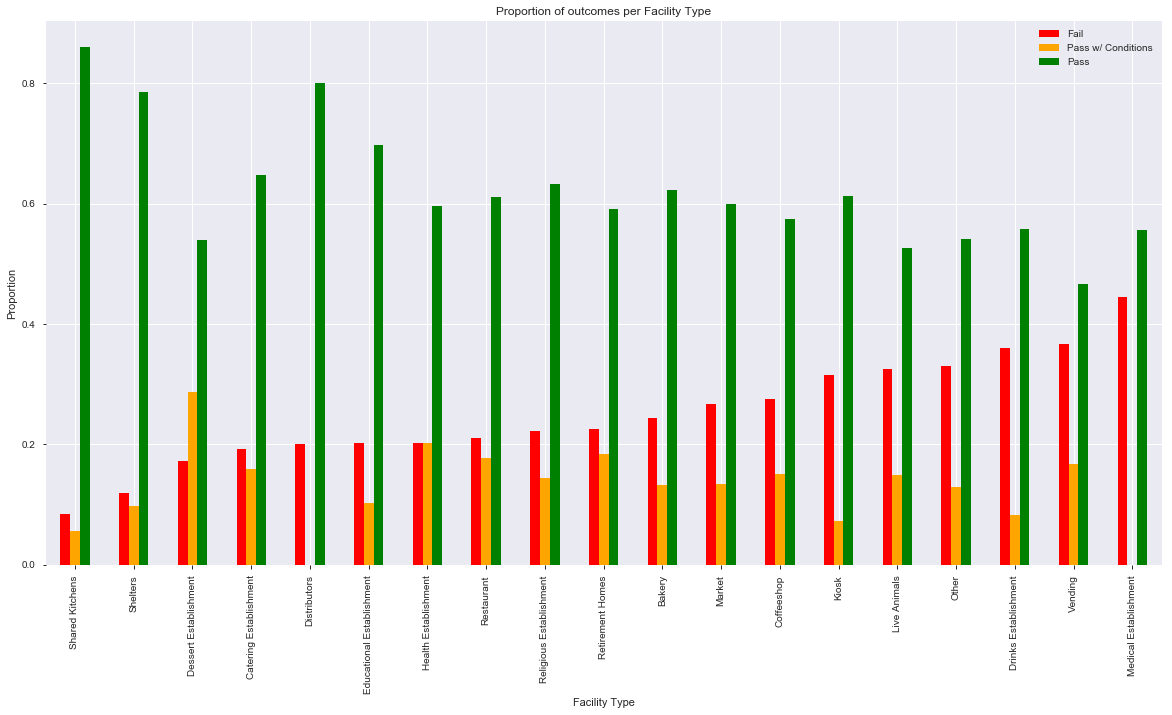

In [153]:
plot_corr_with_results('Facility Type')
plot_corr_with_results_plotly('Facility Type', 'facilitytype.html')

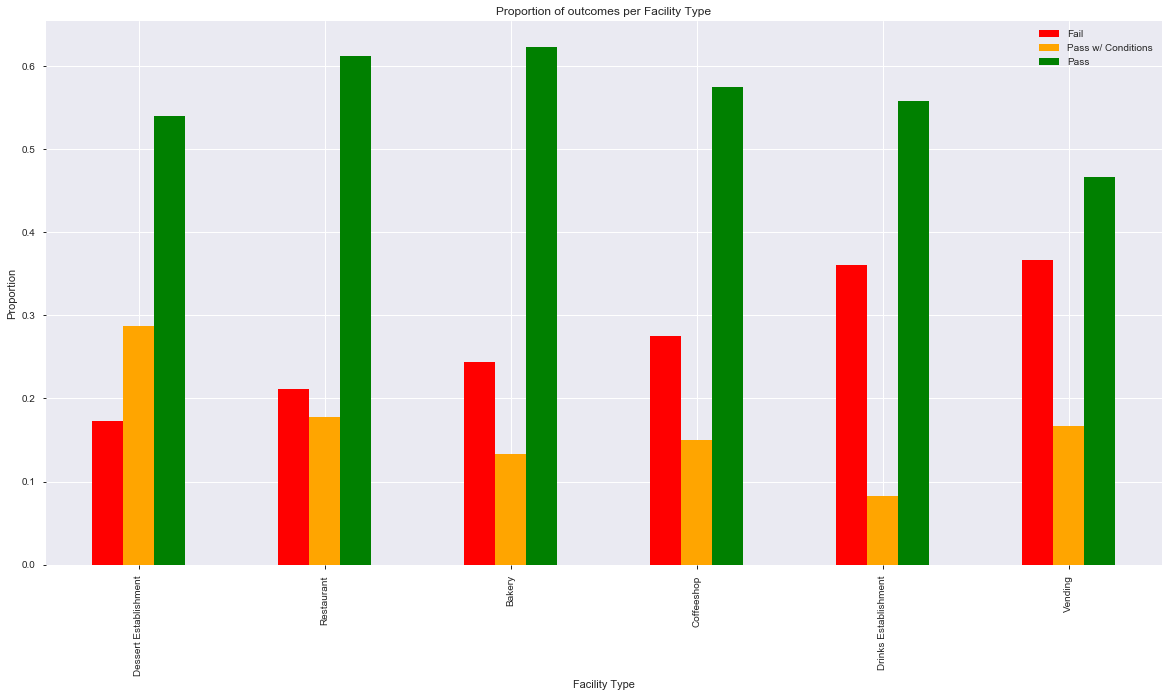

In [154]:
plot_corr_with_results_plotly('Facility Type', filename='facilitytypesmall.html', df=inspections[inspections['Facility Type'].isin(['Bakery', 'Restaurant', 'Drinks Establishment', 'Coffeeshop', 'Vending', 'Dessert Establishment'])])
plot_corr_with_results('Facility Type', df=inspections[inspections['Facility Type'].isin(['Bakery', 'Restaurant', 'Drinks Establishment', 'Coffeeshop', 'Vending', 'Dessert Establishment'])])

We notice the following:

* Dessert establishments seem to have the highest number of passes with conditions. This might be due to lack of refrigeration. Given that this is not highly risky and can be easily fixed, it makes sense to give them a pass with conditions.
* Medical establishments do not get passes with conditions. They either get passes or fails. This makes sense as food sanitation is a top priority in medical establishments given that most of their customers are patients. Mecial establishments also have the highest number of failed inspections. This might be due to a stricter approach taken with them given that food cleaniness is the top priority for such facilities.
* Distributors also do not have any passes with conditions. This might be due to the rules surrounding inspections. It might also be due to the fact that any violations found are usually not caused by the distributor itself but rather by the providers of the products to be distributed. Hence, they also have the biggest proportion of passes.
* Shared kitchens have the biggest proportions of passes which reflects positively on people using them.
* In general, on average the proportions of results seem very different in terms of type of establishment. But we can notice establishment types which form groups that have similar distributions of results. For example, restaurants, religious establishments and retirement homes seem to have very similar result distributions.

Let us turn our attention to the community area and its effect on the inspection outcomes.

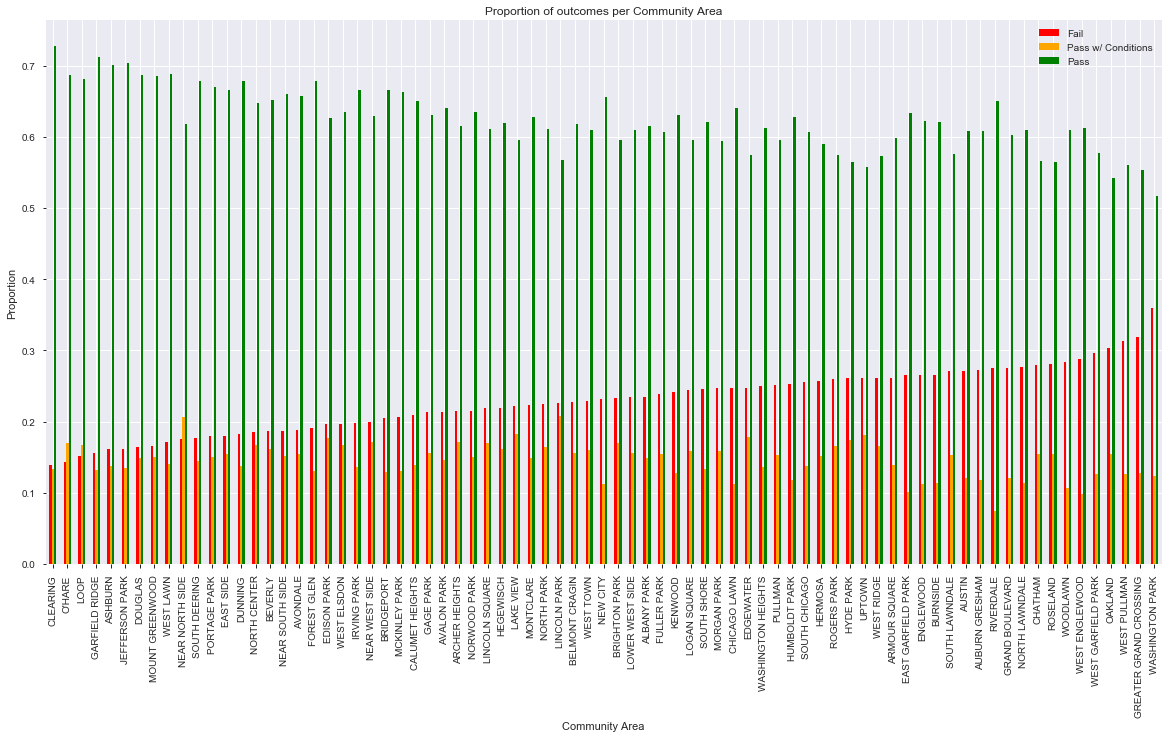

In [155]:
plot_corr_with_results_plotly('Community Area', 'communityareas.html')
plot_corr_with_results('Community Area')

We notice the following:

* Washington Park has the highest proportion of failes inspections. This is interesting as the dominating ethnicity in the neighborhood is African-American. This is in contrast to Clearing which has the highest proportion of passed inspections and has 1% African American population.

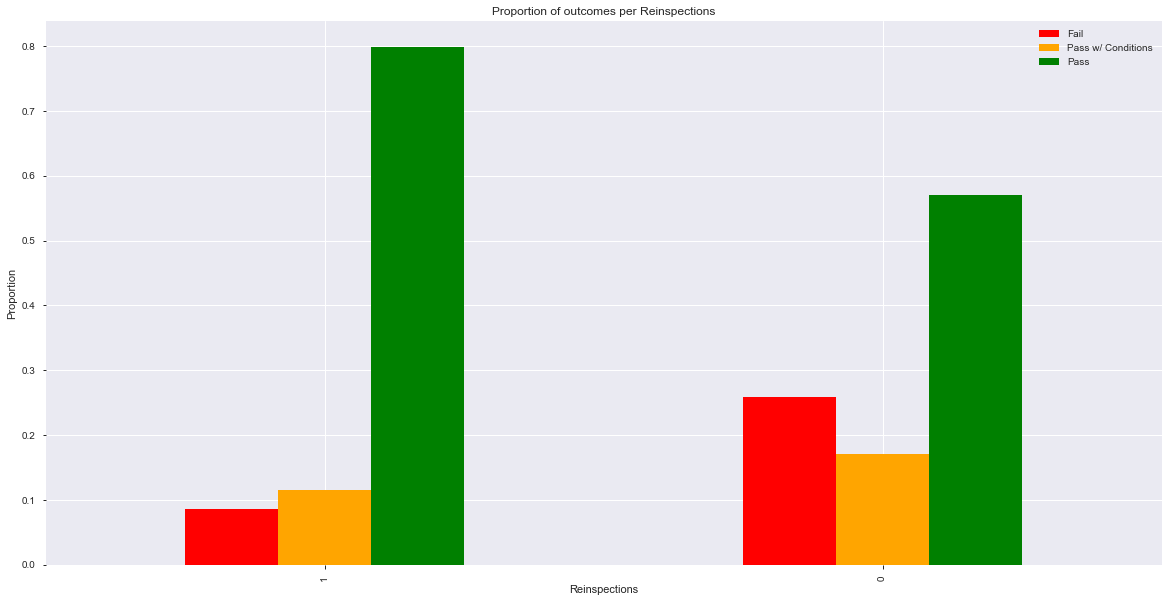

In [156]:
plot_corr_with_results_plotly('Reinspections', 'reinspections.html')
plot_corr_with_results('Reinspections')

We notice the following:

* We can clearly see that the proportion of facilities which get a pass in reinspection is bigger than that which gets a pass at the first inspection. This makes sense as establishments take into consideration the comments given by the inspector for the reinspection.
* We can alse see that the proportion of passes with conditions is smaller for the reinspections. This makes sense as giving such a result would mean giving establishments "a third chance".

Now we look at the inspection type.

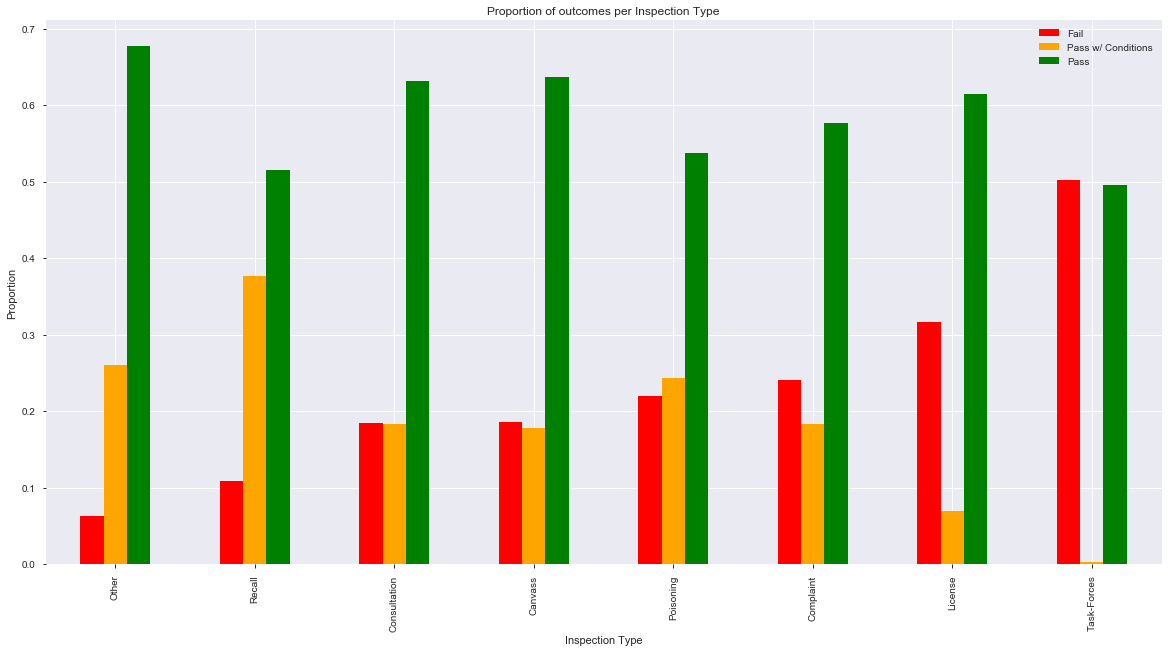

In [157]:
plot_corr_with_results_plotly('Inspection Type', 'inspectiontype.html')
plot_corr_with_results('Inspection Type')

We observe the following:

* In terms of failed inspections, the license and the task-force (liquor license inspections) types have the highest proportions. For the license, this might be due to the fact that the facility is usually newly established and hence fairly inexperienced. It is unclear why task-force inspections but it might be due to the sensitive nature of alcoholic products in the sense that sales of such products must be handled with care (warning sign for minors, proper age check etc).
* In general, the number of passes seem very similar accross all inspection types. However, they seem to be below average for the poisoning, recall and task-force inspections.
    * For poisoning, the reason is probably the severity of the complaint which cause the inspections. Inspectors must be following stricter guidlines
    * For recall, it is below average due to the above average proportion of passes with conditions. This could actually be used to justify having recall inspections as they are done to make sure that establishmenst which have performed well in the past continue to perform well.
    * For task forces, it is due to very high proportion to fails, which is explained above.

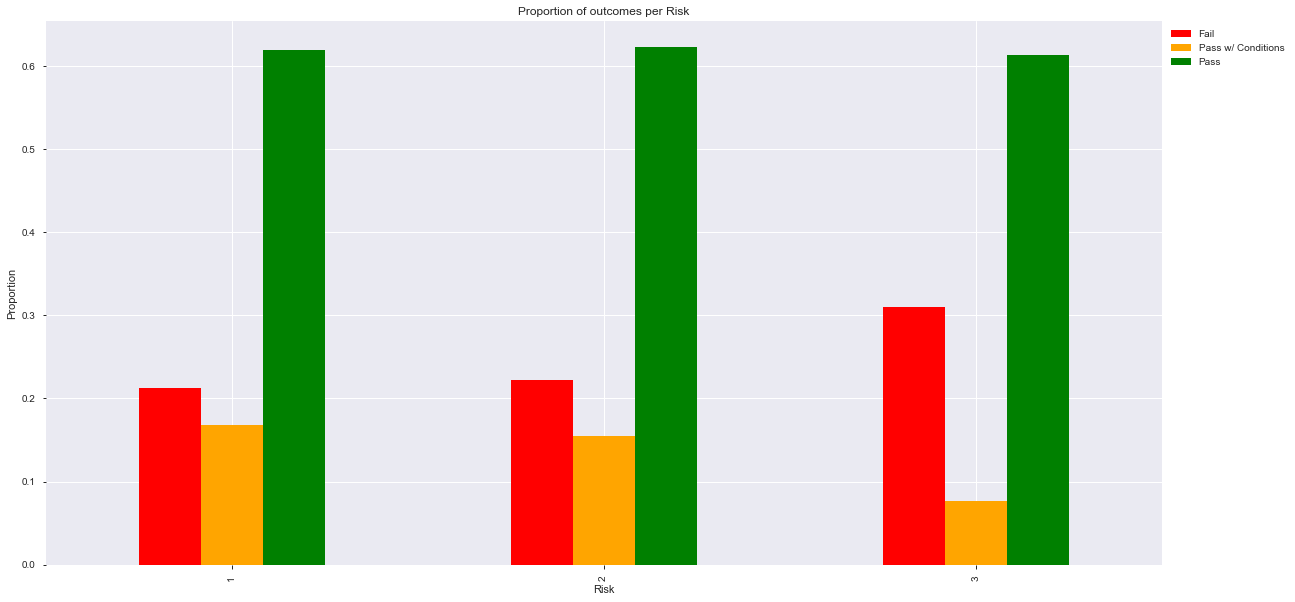

In [158]:
plot_corr_with_results_plotly('Risk', 'risk.html')
plot_corr_with_results('Risk')

We notice the following:

* Establishments with the highest risk seem to get the least fails, surprisingly. This might be due to their awareness of matter and hence their care in maintaining their sanitation.
* Establishments with the highest risk also get the highest proportion of passes with conditions. This could mean that inspectors might be less severe with them given that it is very challenging to maintain such a risky establishment.
* The proportion of passes seems independent of the risk of the facility.

# III. Chains

In [159]:
chains_inspections = pd.read_pickle('pickles/chains_inspections.pickle')
chains_inspections = chains_inspections[chains_inspections['Results'].isin(['Pass w/ Conditions', 'Fail', 'Pass'])]

In [160]:
fast_foods = pd.read_csv('datasets/FastFoodRestaurants.csv')

chain_counts = (fast_foods['name'].value_counts())
fast_food_chains = chain_counts[chain_counts.values > 1].index.tolist()


additional_chains = inspections[['DBA Name', 'Address', 'Latitude', 'Longitude']].drop_duplicates().reset_index().drop('index', axis=1)
grouped_by_dbaname = additional_chains.groupby(by=['DBA Name']).size().reset_index(name="Count")
establishments_repeted = grouped_by_dbaname[grouped_by_dbaname['Count']>1].reset_index()
other_fast_food_chains = set(establishments_repeted['DBA Name'])


fast_food_chains.extend(other_fast_food_chains)
fast_food_chains.extend(set(chains_inspections['DBA Name'].tolist()))
fast_food_chains = set(fast_food_chains)

In [161]:
inspections['Chain'] = inspections['DBA Name'].apply(lambda i: 1 if i in fast_food_chains else 0)

In [162]:
inspections['Chain'].unique()

array([1, 0])

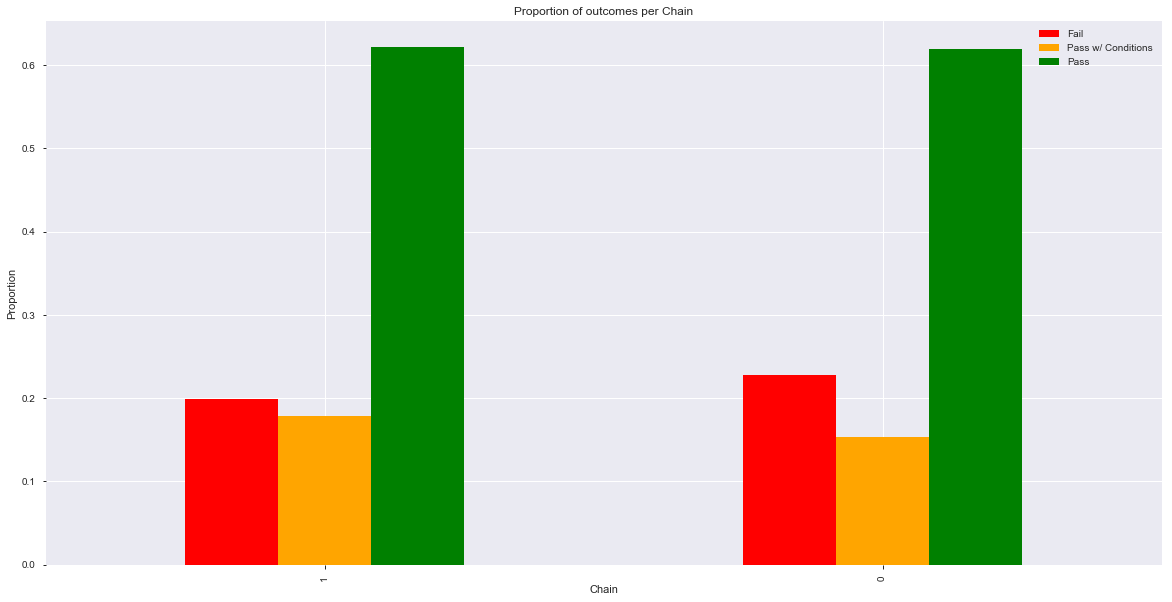

In [163]:
plot_corr_with_results_plotly('Chain', 'chain.html')
plot_corr_with_results('Chain')

We can see that the proportion of fails is higher for non-chains and that the proportion of passes with conditions is higher for chains. This might reveal some form of inequality in inspections are inspectors seem to be less severe with chains as they get more passes with conditions than fails, than with non-chains as they get more fails than passes with conditions.

# IV. Yelp

First, let's extract the yelp dataset and merge it with our inspections dataset.

In [164]:
yelps = pd.read_pickle('./business_details.pickle')
yelp_feats = pd.read_pickle('./pickles/merged_cfi_yelp')

In [165]:
yelp_feats = inspections.merge(yelps, how = 'inner', left_on = 'DBA Name', right_on = 'name')


In [166]:
yelp_feats.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'Inspection Date', 'Inspection Type', 'Results',
       'Violations', 'Latitude', 'Longitude', 'Location', 'Community Area',
       'Violation Numbers', 'Violation Comments', 'Reinspections', 'Chain',
       'alias', 'categories', 'coordinates.latitude', 'coordinates.longitude',
       'display_phone', 'error.code', 'error.description', 'hours', 'id',
       'image_url', 'is_claimed', 'is_closed', 'location.address1',
       'location.address2', 'location.address3', 'location.city',
       'location.country', 'location.cross_streets',
       'location.display_address', 'location.state', 'location.zip_code',
       'messaging.url', 'messaging.use_case_text', 'name', 'phone', 'photos',
       'price', 'rating', 'review_count', 'special_hours', 'transactions',
       'url'],
      dtype='object')

In [167]:
yelp_feats = yelp_feats.drop(columns=['coordinates.latitude', 'coordinates.longitude',
       'display_phone', 'error.code', 'error.description', 'hours', 'id',
       'image_url', 'is_claimed', 'is_closed', 'location.address1',
       'location.address2', 'location.address3', 'location.city',
       'location.country', 'location.cross_streets',
       'location.display_address', 'location.state', 'location.zip_code',
       'messaging.url', 'messaging.use_case_text', 'name', 'phone', 'photos', 
       'special_hours', 'transactions', 'url'])

Now, let's extract the features that are of interest to us.

## A. Cuisine

In [168]:
yelp_feats['categories']

0        [{'alias': 'restaurants', 'title': 'Restaurant...
1        [{'alias': 'restaurants', 'title': 'Restaurant...
2        [{'alias': 'restaurants', 'title': 'Restaurant...
3        [{'alias': 'restaurants', 'title': 'Restaurant...
4        [{'alias': 'restaurants', 'title': 'Restaurant...
                               ...                        
43514    [{'alias': 'childcare', 'title': 'Child Care &...
43515    [{'alias': 'childcare', 'title': 'Child Care &...
43516    [{'alias': 'childcare', 'title': 'Child Care &...
43517    [{'alias': 'musicvenues', 'title': 'Music Venu...
43518           [{'alias': 'lounges', 'title': 'Lounges'}]
Name: categories, Length: 43519, dtype: object

The cuisine is part of the dictionary in the 'categories' column. Let us hence extract the cuisine.

In [169]:
yelp_feats['categories'] = yelp_feats['categories'].apply(lambda x: [] if type(x) is float else x)

In [170]:
yelp_feats['categories'] = yelp_feats['categories'].apply(lambda x: x[0]['alias'] if len(x) > 0 else 'unknown')

In [171]:
yelp_feats['categories'].unique()

array(['restaurants', 'pizza', 'italian', 'tapas', 'bakeries', 'coffee',
       'hotdogs', 'burgers', 'sandwiches', 'chicken_wings',
       'servicestations', 'chinese', 'venues', 'cafes', 'cheese',
       'tradamerican', 'asianfusion', 'icecream', 'indpak',
       'breakfast_brunch', 'donuts', 'mediterranean', 'spas',
       'elementaryschools', 'bars', 'pubs', 'vietnamese', 'candy',
       'gourmet', 'cookingschools', 'popcorn', 'ramen', 'mexican',
       'convenience', 'latin', 'sportsbars', 'newamerican', 'vegetarian',
       'sushi', 'delis', 'japanese', 'buffets', 'mideastern', 'chocolate',
       'french', 'culturalcenter', 'juicebars', 'beer_and_wine',
       'puertorican', 'retirement_homes', 'hotdog', 'beerbar',
       'tapasmallplates', 'childcare', 'nonprofit', 'highschools',
       'foodtrucks', 'desserts', 'filipino', 'diners', 'creperies',
       'steak', 'collegeuniv', 'lounges', 'brazilian', 'bbq', 'wine_bars',
       'divebars', 'montessori', 'discountstore', 'fooddel

In [172]:
yelp_feats = yelp_feats.rename(columns={'categories': 'Cuisine'})

A quick google search gives us the most popular cuisines. We choose to plot inspection outcomes for those cuisines in particular.

In [173]:
pop_cuisines = ['italian', 'japanses', 'tapas','chinese','tradamerican','mediterranean',
                'diners', 'mexican', 'korean', 'greek', 'pakistani', 'peruvian',
                'german', 'spanish', 'indonesian', 'turkish', 'british']
yelp_cuisines = yelp_feats[yelp_feats['Cuisine'].isin(pop_cuisines)]
yelp_prices = yelp_feats.dropna(subset=['Cuisine'])

In [174]:
len(yelp_cuisines)

4306

Now we can plot the outcomes in terms of the cuisine.

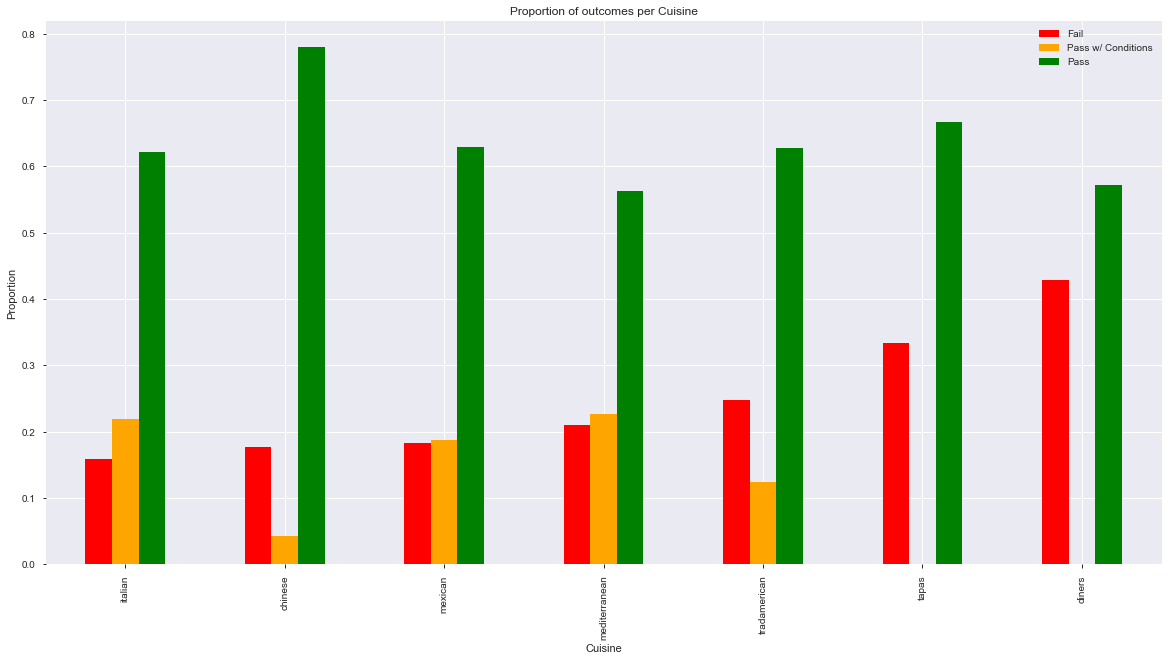

In [175]:
plot_corr_with_results_plotly('Cuisine', 'cuisine.html', yelp_cuisines)
plot_corr_with_results('Cuisine', yelp_cuisines)

We notice the following:

* Diners have the highest fail proportion. This might be intuitive as they usually mostly serve "fast food" and do not have the best reputation when it comes to health and cleaniness.
* Chinese restaurants have the highest pass proportion.
* Overall, we can see that inspection results do at least partly differ according to cuisine type.

## B. Price Range

In [176]:
yelp_feats = yelp_feats.rename(columns={'price': 'Price Range'})

In [177]:
yelp_prices = yelp_feats.dropna(subset=['Price Range'])

In [178]:
yelp_prices['Price Range'] = yelp_prices['Price Range'].apply(lambda x: len(x))

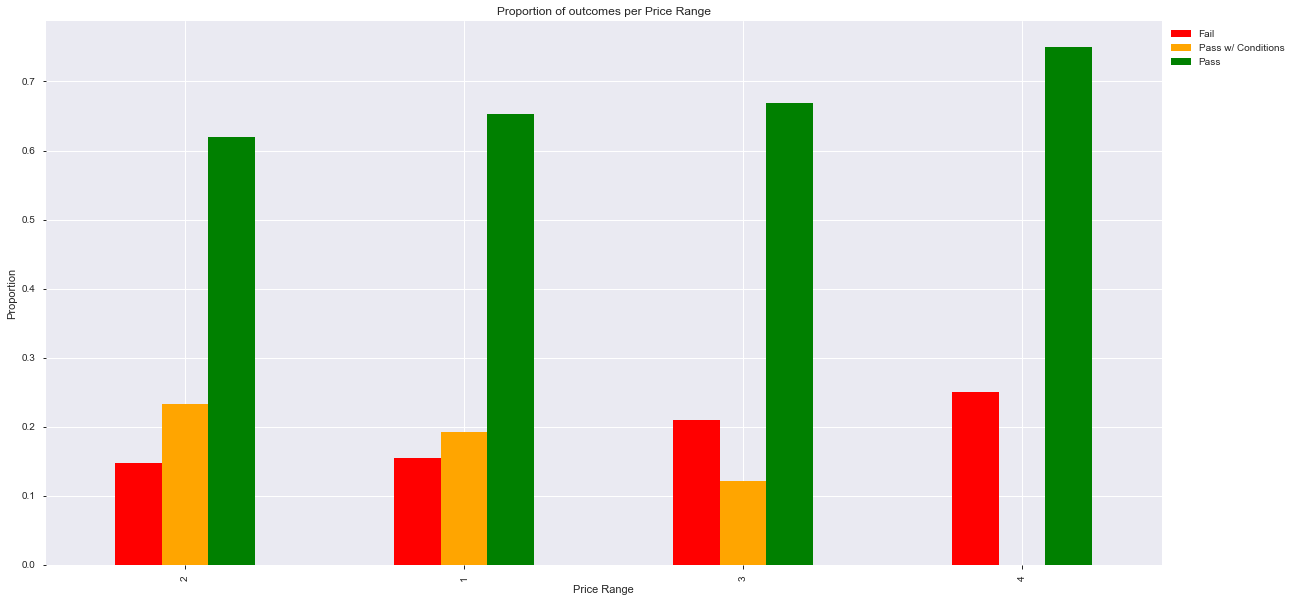

In [179]:
plot_corr_with_results_plotly('Price Range', 'price.html', yelp_prices)
plot_corr_with_results('Price Range', yelp_prices)

We notice the following:

* The most expensive restaurants have the highest fail proportion but also the highest pass proportion as they do not seem to have any passes with conditions. This seems counter-intuitive as we would have expected the cheapest restaurants to have the highest fail proportion.
* The proportions of passes seem consistant for the three least expensive establishment categories.

## C. User Rating

In [180]:
yelp_feats = yelp_feats.rename(columns={'rating': 'User Rating'})

In [181]:
yelp_ratings = yelp_feats.dropna(subset=['User Rating'])

In [182]:
yelp_ratings

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,...,Community Area,Violation Numbers,Violation Comments,Reinspections,Chain,alias,Cuisine,Price Range,User Rating,review_count
0,2059948,Subway Sandwiches,Subway,1621730,Restaurant,1,2620 N NARRAGANSETT AVE,2017-06-09,Canvass,Pass,...,BELMONT CRAGIN,NaN,NaN,1,1,subway-sandwiches-chicago-4,restaurants,$,4.0,1.0
1,2059948,Subway Sandwiches,Subway,1621730,Restaurant,1,2620 N NARRAGANSETT AVE,2017-06-09,Canvass,Pass,...,BELMONT CRAGIN,NaN,NaN,1,1,subway-sandwiches-chicago-4,restaurants,$,4.0,1.0
2,2059503,Subway Sandwiches,Subway,1621730,Restaurant,1,2620 N NARRAGANSETT AVE,2017-06-02,Canvass,Fail,...,BELMONT CRAGIN,"[11, 18, 24, 33, 34, 35, 38]",[ OBSERVED NO HAND WASHING SINK IN REAR DISH W...,0,1,subway-sandwiches-chicago-4,restaurants,$,4.0,1.0
3,2059503,Subway Sandwiches,Subway,1621730,Restaurant,1,2620 N NARRAGANSETT AVE,2017-06-02,Canvass,Fail,...,BELMONT CRAGIN,"[11, 18, 24, 33, 34, 35, 38]",[ OBSERVED NO HAND WASHING SINK IN REAR DISH W...,0,1,subway-sandwiches-chicago-4,restaurants,$,4.0,1.0
4,1953572,Subway Sandwiches,Subway,1621730,Restaurant,1,2620 N NARRAGANSETT AVE,2016-08-31,Canvass,Pass,...,BELMONT CRAGIN,[35],"[ GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CL...",0,1,subway-sandwiches-chicago-4,restaurants,$,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43514,413246,Tots Express Learning Center,Tots Express Learning Center,2002536,Educational Establishment,1,1705-07 E 87th ST FL,2010-09-09,License,Pass,...,AVALON PARK,NaN,NaN,0,0,tots-express-learning-center-chicago-2,childcare,NaN,5.0,1.0
43515,335236,Tots Express Learning Center,Tots Express Learning Center,2002536,Educational Establishment,1,1705-07 E 87th ST FL,2010-08-10,Canvass,Pass,...,AVALON PARK,NaN,NaN,0,0,tots-express-learning-center-chicago-2,childcare,NaN,5.0,1.0
43516,68250,Tots Express Learning Center,Tots Express Learning Center,2002536,Educational Establishment,1,1705-07 E 87th ST FL,2010-01-05,License,Pass,...,AVALON PARK,NaN,NaN,1,0,tots-express-learning-center-chicago-2,childcare,NaN,5.0,1.0
43517,278124,Kinetic Playground,Kinetic Playground,473,Drinks Establishment,3,1113 W LAWRENCE AVE,2010-08-06,Canvass,Pass w/ Conditions,...,UPTOWN,NaN,NaN,0,0,kinetic-playground-chicago,musicvenues,$$,3.0,25.0


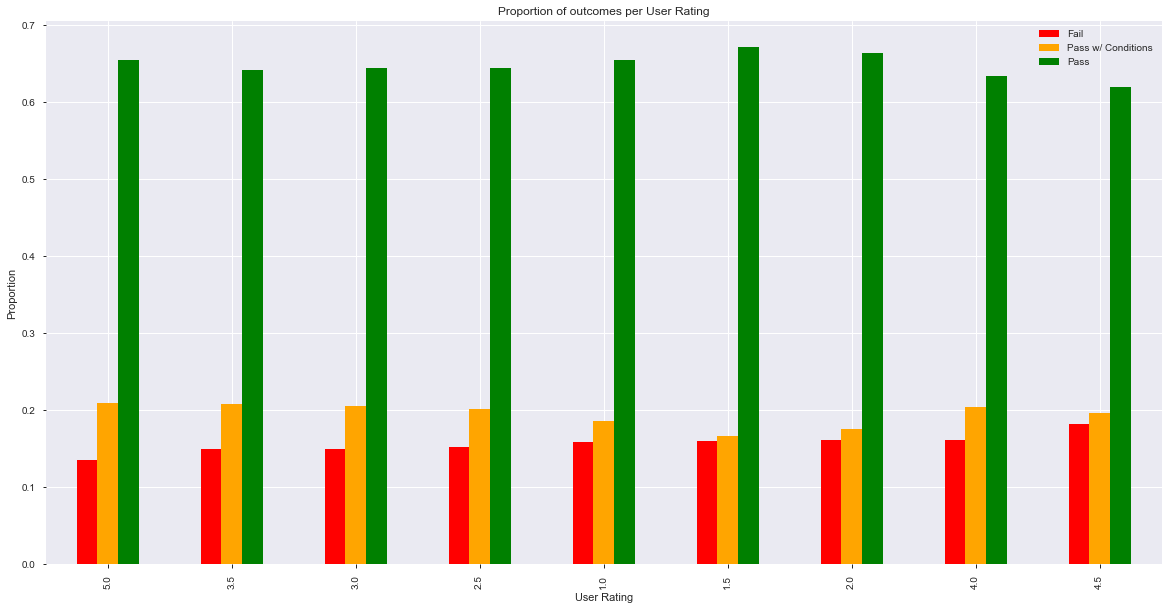

In [183]:
plot_corr_with_results_plotly('User Rating', 'userrating.html', yelp_ratings)
plot_corr_with_results('User Rating', yelp_ratings)

We notice that the user rating does not seem to have an influence over the inspection outcome. They are in fact mostly consistent accross user ratings. This is counterintuitive as one would have expected more expensive restaurants to have more passes and less fails.

# V. Evolution of results

## A. Proportions of outcomes per unit of time

In [192]:
def evol(df, subset='all', scale='year'):
    """
    Function to plot the evolution of the inspection outcomes through the years
    Arguments:
    df - dataframe to consider for the evolution
    Returns:
    None
    """
    corr = df[['Inspection ID', 'Results', 'Inspection Date']]
    if scale == 'day':
        corr['Inspection Date'] = corr['Inspection Date'].apply(lambda date : calendar.day_name[date.weekday()])
        cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        cat_type = CategoricalDtype(categories=cats, ordered=True)
        corr['Inspection Date'] = corr['Inspection Date'].astype(cat_type)
    elif scale == 'month':
        corr['Inspection Date'] = corr['Inspection Date'].apply(lambda date : date.month)
    else:
        corr['Inspection Date'] = corr['Inspection Date'].apply(lambda date : date.year)
    
    coor_tot = corr.groupby('Inspection Date').count().reset_index()[['Inspection Date', 'Inspection ID']].rename(columns={"Inspection ID": 'Count'})
    corr = corr.groupby(['Inspection Date','Results']).count().reset_index().rename(columns={"Inspection ID": 'Count'})
    corr = corr.merge(coor_tot, on='Inspection Date')
    corr['Count'] = corr['Count_x']/corr['Count_y']
    corr = corr.drop(columns=['Count_x', 'Count_y'])
    
    if subset=='Fail':
        pivot_df = corr[corr['Results'] == 'Fail'].pivot(index='Inspection Date', columns='Results', values='Count')
        pivot_df.sort_values(by='Fail',ascending=True).plot.bar(stacked=False, figsize=(20,10),title='Number of outcomes per {}'.format('Inspection Date'), colors=['red'])
    elif subset == 'Pass':
        pivot_df = corr[corr['Results'] == 'Pass'].pivot(index='Inspection Date', columns='Results', values='Count')
        pivot_df.sort_values(by='Pass',ascending=True).plot.bar(stacked=False, figsize=(20,10),title='Proportion of outcomes per {}'.format('Inspection Date'), colors=['green'])
    elif subset == 'Pass w/ Conditions':
        pivot_df = corr[corr['Results'] == 'Pass w/ Conditions'].pivot(index='Inspection Date', columns='Results', values='Count')
        pivot_df.sort_values(by='Pass w/ Conditions',ascending=True).plot.bar(stacked=False, figsize=(20,10),title='Number of outcomes per {}'.format('Inspection Date'), colors=['orange'])
    else:
        pivot_df = corr.pivot(index='Inspection Date', columns='Results', values='Count')
        pivot_df = pivot_df[['Fail', 'Pass w/ Conditions', 'Pass']]
        pivot_df.sort_values(by='Fail',ascending=True).plot.bar(stacked=False, figsize=(20,10),title='Number of outcomes per {}'.format('Inspection Date'), colors=['red', 'orange', 'green'])
    plt.ylabel('Proportion')
    plt.legend(bbox_to_anchor=(1, 1), loc='left', ncol=1)


In [185]:
def evol_plotly(df, filename, scale='year'):
    """
    Function to plot the evolution of the inspection outcomes through the years using plotly (interactive)
    Arguments:
    df - dataframe to consider for the evolution
    Returns:
    None
    """
    corr = df[['Inspection ID', 'Results', 'Inspection Date']]
    scale = 'year'
    if scale == 'day':
        corr['Inspection Date'] = corr['Inspection Date'].apply(lambda date : calendar.day_name[date.weekday()])
        cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        cat_type = CategoricalDtype(categories=cats, ordered=True)
        corr['Inspection Date'] = corr['Inspection Date'].astype(cat_type)
    elif scale == 'month':
        corr['Inspection Date'] = corr['Inspection Date'].apply(lambda date : date.month)
    else:
        corr['Inspection Date'] = corr['Inspection Date'].apply(lambda date : date.year)

        coor_tot = corr.groupby('Inspection Date').count().reset_index()[['Inspection Date', 'Inspection ID']].rename(columns={"Inspection ID": 'Count'})
        corr = corr.groupby(['Inspection Date','Results']).count().reset_index().rename(columns={"Inspection ID": 'Count'})
        corr = corr.merge(coor_tot, on='Inspection Date')
        corr['Count'] = corr['Count_x']/corr['Count_y']
        corr = corr.drop(columns=['Count_x', 'Count_y'])
    colors = {'Pass': 'green', 'Pass w/ Conditions': 'orange', 'Fail': 'red'}
    categories = ['Pass', 'Pass w/ Conditions', 'Fail']
    fig = go.Figure(data=[
        go.Bar(name=i,
               x=corr[corr['Results'] == i]['Inspection Date'].values,
               y=corr[corr['Results'] == i]['Count'].values,
               marker=dict(
                color=colors[i]
                )
              ) for i in categories])
    # Change the bar mode
    fig.update_layout(
        barmode='group',
        title={
            'text': 'Proportion of outcomes per {}'.format(scale),
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        xaxis_title=column,
        yaxis_title='Proportion')
    plotly.offline.plot(fig, filename=filename)
    fig.show()

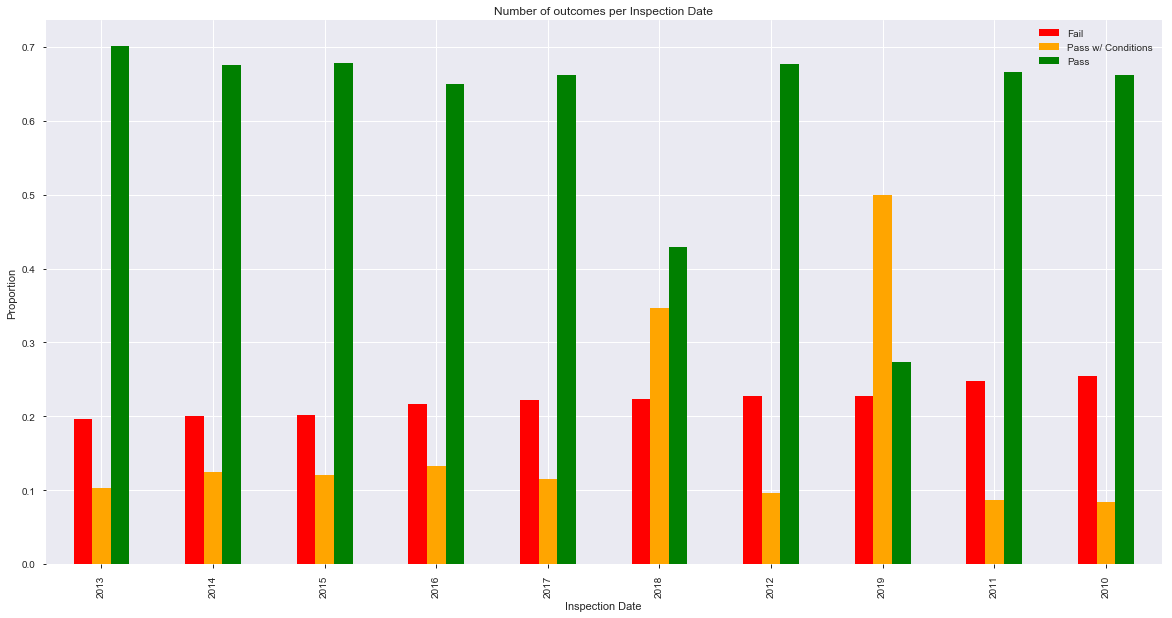

In [186]:
evol(inspections)
evol_plotly(inspections, 'year.html')

We can see a clear evolution in terms of the number of passes vs the number of passes with conditions. The number of passes decreases through the years, to be replaced by the number of passes with conditions. This reflects a more severe inspection process in recent years (2018, 2019) compared to inspection results prior to those years.

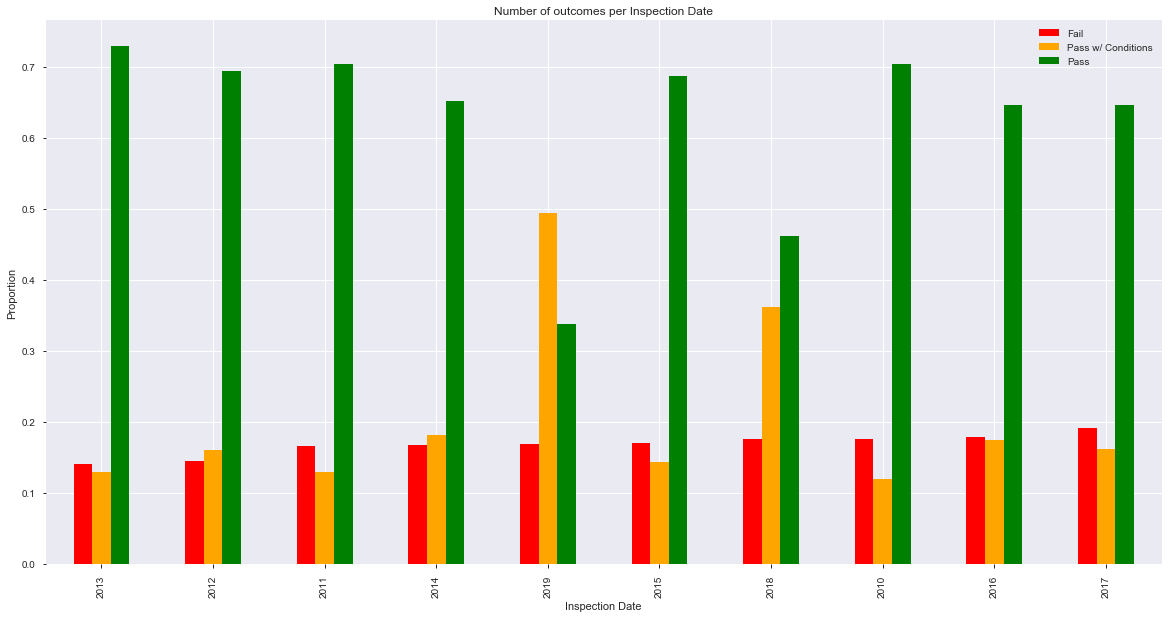

In [187]:
evol(chains_inspections)
evol_plotly(chains_inspections, 'year_chains.html')

There is no significant difference between the evolution of inspection outcomes for chains and for non-chains as we can see if we compare the two plots above.

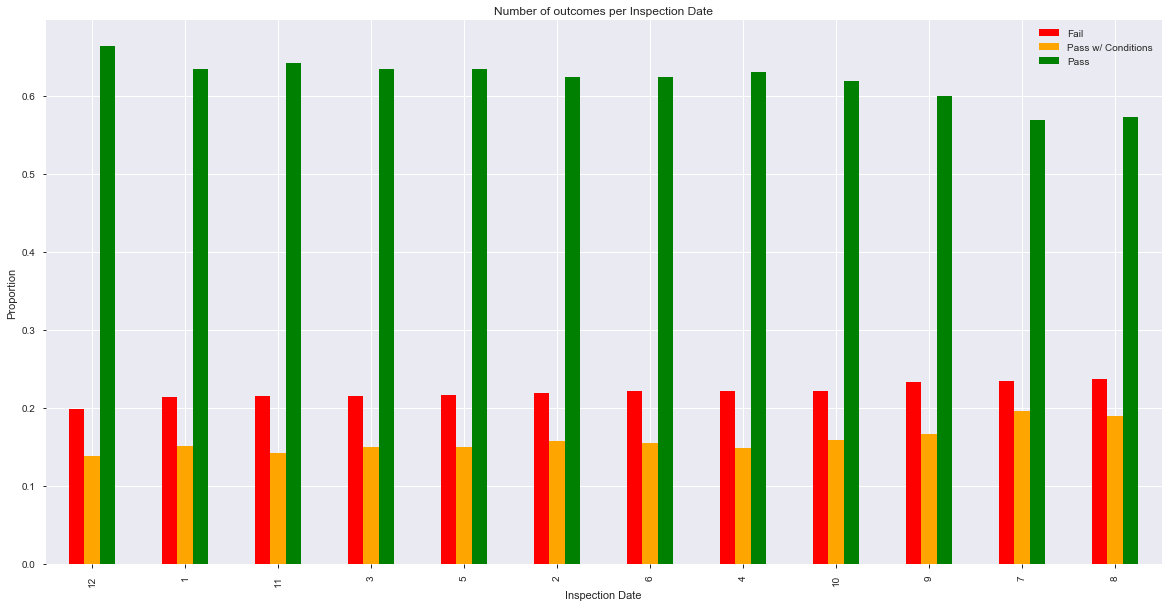

In [188]:
evol(inspections, scale='month')
evol_plotly(inspections, 'month.html', scale='month')

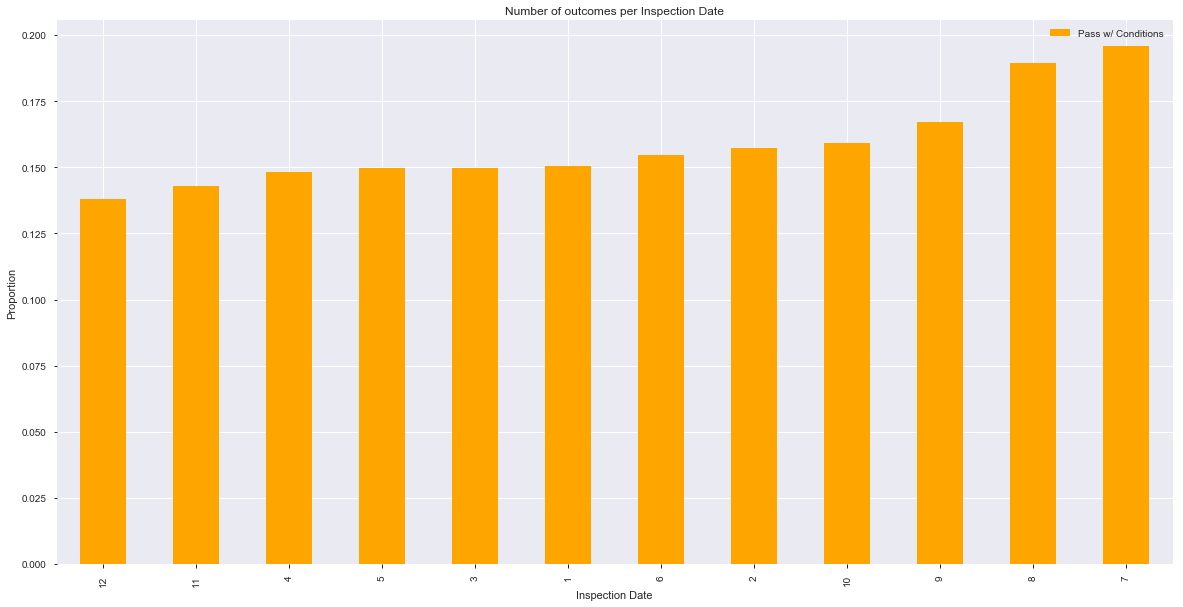

In [193]:
evol(inspections, subset='Pass w/ Conditions', scale='month')

We can see that the number of passes with conditons varies with the months. This could relate to the hot weather and the lack of refrigeration in the summer months and the number of passes with conditions sees its peak during those months.

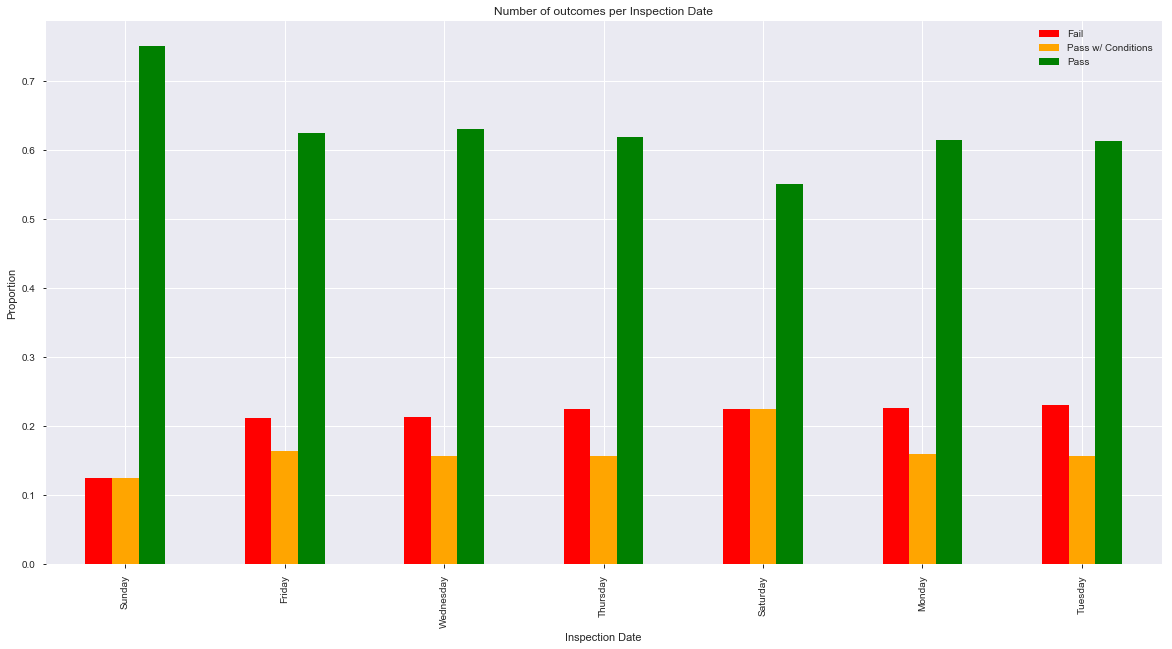

In [190]:
evol(inspections, scale='day')
evol_plotly(inspections, 'day.html', scale='day')

## B. Attempting to track facility evolution

Here, we try to track individual establishment evolution. To this end, we detect the establishments which had failed inspections in the first six months of an arbitrary year (2017). We then track their inspection outcomes in the second half of the year to see whether they have improved or not.

In [106]:
inspections_evol = inspections.copy()
# getting exact address of facilities by concatenating name and address
inspections_evol['Exact Address'] = inspections_evol['DBA Name'].map(lambda i : '{}, '.format(i)) + inspections_evol['Address']
inspections_evol = inspections_evol[['Results', 'Exact Address', 'Inspection Date']]
# for easier manipulation
inspections_evol['Results'] = inspections_evol['Results'].replace(results_dict)


In [107]:
# getting the failed inspections in the first 6 months of 2017
fails = inspections_evol[inspections_evol['Inspection Date'].isin(pd.date_range(start='1/1/2017', end='1/6/2017'))]
fails = fails[fails['Results'] == 0]


In [108]:
fails = fails.rename(columns={'Results': 'Results in first 6 months'})

In [109]:
fails

,Results in first 6 months,Exact Address,Inspection Date
6289,0,"FIRST CHOICE MARKET, 3019 E 91ST ST",2017-01-06
11788,0,"GEORGIAN BAKERY, 2812 W DEVON AVE",2017-01-04
12552,0,"WILD BLOSSOM II & SOUTH WORKS BREWING CO., 901...",2017-01-03
12553,0,"WILD BLOSSOM II & SOUTH WORKS BREWING CO., 901...",2017-01-03
12684,0,"WENDY'S, 7601 S CICERO AVE",2017-01-06
13127,0,"CHINESE YUM YUM, 809 W JACKSON BLVD",2017-01-06
18932,0,"DUNKIN DONUTS, 100 W RANDOLPH ST",2017-01-06
18935,0,"AMERICA'S DOG, 100 W RANDOLPH ST",2017-01-04
21743,0,"ACME HOTEL COMPANY/THE BERKSHIRE, 15 E OHIO ST",2017-01-05
24593,0,"CLAYTON RESIDENTIAL HOME INC, 2026 N CLARK ST",2017-01-06


In [110]:
# getting the evolution of the establishments with fails in the first 6 months
evolution = inspections_evol[inspections_evol['Inspection Date'].isin(pd.date_range(start='2/6/2017', end='31/12/2017'))]
evolution = evolution[evolution['Exact Address'].isin(fails['Exact Address'])]
evolution

,Results,Exact Address,Inspection Date
6284,2,"FIRST CHOICE MARKET, 3019 E 91ST ST",2017-11-17
6285,2,"FIRST CHOICE MARKET, 3019 E 91ST ST",2017-06-19
6286,2,"FIRST CHOICE MARKET, 3019 E 91ST ST",2017-06-06
6287,2,"FIRST CHOICE MARKET, 3019 E 91ST ST",2017-05-04
11783,1,"GEORGIAN BAKERY, 2812 W DEVON AVE",2017-11-16
13123,2,"CHINESE YUM YUM, 809 W JACKSON BLVD",2017-07-25
13124,2,"CHINESE YUM YUM, 809 W JACKSON BLVD",2017-02-17
18898,2,"AMERICA'S DOG, 100 W RANDOLPH ST",2017-10-12
18901,0,"AMERICA'S DOG, 100 W RANDOLPH ST",2017-10-05
18904,2,"DUNKIN DONUTS, 100 W RANDOLPH ST",2017-09-28


In [111]:
tmp = pd.concat([fails, evolution])

In [112]:
len(inspections_evol.groupby(['Exact Address']))

26896

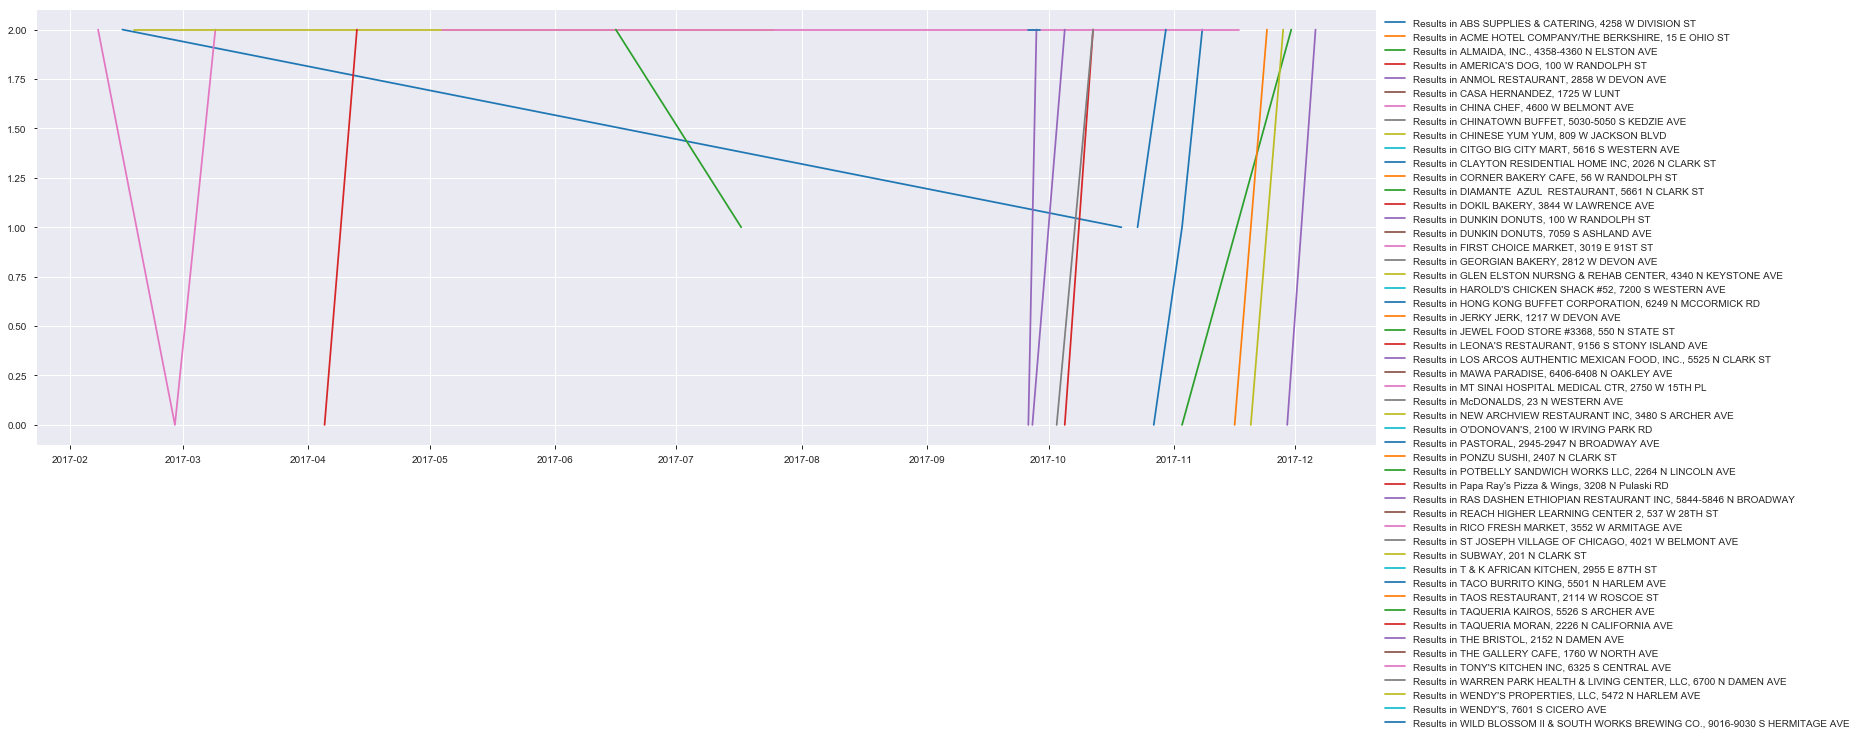

In [129]:
fig, ax = plt.subplots(figsize=(24,8))
# ax.plot(inspections_evol.loc['2017-01':'2017-02', 'Consumption'], marker='o', linestyle='-'
start_dt = date(2017, 12, 1)
end_dt = date(2017, 12, 31)
for key, grp in tmp.groupby(['Exact Address']):
    ax.plot(grp['Inspection Date'], grp['Results'], label = "Results in {}".format(key))   
plt.legend(bbox_to_anchor=(1, 1), loc='lower', ncol=1)
plt.savefig('evolution.png')

We can see that most restaurants do get better inspection results after fails.